<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## LSTM Bot QA

### Datos
El objecto es utilizar datos disponibles del challenge ConvAI2 (Conversational Intelligence Challenge 2) de conversaciones en inglés. Se construirá un BOT para responder a preguntas del usuario (QA).\
[LINK](http://convai.io/data/)

In [1]:

import numpy as np
import pandas as pd
import tensorflow as tf
import re
from keras.preprocessing.text import one_hot
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM, SimpleRNN
from keras.models import Model
from keras.layers import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input

In [2]:
# dataset
import os
import gdown
if os.access('data_volunteers.json', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1awUxYwImF84MIT5-jCaYAPe2QwSgS1hN&export=download'
    output = 'data_volunteers.json'
    gdown.download(url, output, quiet=False)
else:
    print("El dataset ya se encuentra descargado")

Downloading...
From: https://drive.google.com/uc?id=1awUxYwImF84MIT5-jCaYAPe2QwSgS1hN&export=download
To: /content/data_volunteers.json
100%|██████████| 2.58M/2.58M [00:00<00:00, 100MB/s]


In [3]:
# dataset_file
import json

text_file = "data_volunteers.json"
with open(text_file) as f:
    data = json.load(f) # la variable data será un diccionario

In [4]:
# Observar los campos disponibles en cada linea del dataset
data[0].keys()

dict_keys(['dialog', 'start_time', 'end_time', 'bot_profile', 'user_profile', 'eval_score', 'profile_match', 'participant1_id', 'participant2_id'])

In [5]:
chat_in = []
chat_out = []

input_sentences = []
output_sentences = []
output_sentences_inputs = []
max_len = 30

def clean_text(txt):
    txt = txt.lower()
    txt.replace("\'d", " had")
    txt.replace("\'s", " is")
    txt.replace("\'m", " am")
    txt.replace("don't", "do not")
    txt = re.sub(r'\W+', ' ', txt)

    return txt

for line in data:
    for i in range(len(line['dialog'])-1):
        # Preguntas y respuestas
        chat_in = clean_text(line['dialog'][i]['text'])
        chat_out = clean_text(line['dialog'][i+1]['text'])

        if len(chat_in) >= max_len or len(chat_out) >= max_len:
            continue

        input_sentence, output = chat_in, chat_out

        # output sentence (decoder_output) tiene <eos>
        output_sentence = output + ' <eos>'
        # output sentence input (decoder_input) tiene <sos>
        output_sentence_input = '<sos> ' + output

        input_sentences.append(input_sentence)
        output_sentences.append(output_sentence)
        output_sentences_inputs.append(output_sentence_input)

print("Cantidad de rows utilizadas:", len(input_sentences))

Cantidad de rows utilizadas: 6033


In [6]:
input_sentences[1], output_sentences[1], output_sentences_inputs[1]

('hi how are you ', 'not bad and you  <eos>', '<sos> not bad and you ')

### 2 - Preprocesamiento

Buscamos obtener `word2idx`, `max_input_len`, `max_out_len`, `num_words_output`

In [7]:
# Establecemos un máximo de vocabulario
MAX_VOCAB_SIZE = 8000

In [8]:
# Definimos el número máximo de palabras a utilizar
from keras.preprocessing.text import Tokenizer

# Filtramos con una expresion regular todos los caracteres especiales
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='!"#$%&()*+,-./:;=¿?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(["<sos>", "<eos>"] + input_sentences + output_sentences)

input_integer_seq = tokenizer.texts_to_sequences(input_sentences)
output_integer_seq = tokenizer.texts_to_sequences(output_sentences)
output_input_integer_seq = tokenizer.texts_to_sequences(output_sentences_inputs)

word2idx = tokenizer.word_index
max_input_len = max(len(sen) for sen in input_integer_seq)
max_out_len = max(len(sen) for sen in output_integer_seq)

# Numero de palabras +1 para incluir la palabra desconocida
num_words_output = min(len(word2idx) + 1, MAX_VOCAB_SIZE)

print("Palabras en el vocabulario:", len(word2idx))
print("Sentencia de entrada más larga:", max_input_len)
print("Sentencia de salida más larga:", max_out_len)

Palabras en el vocabulario: 2157
Sentencia de entrada más larga: 9
Sentencia de salida más larga: 10


In [9]:
# Hacemos el padding del encoder al comienzo y al final
encoder_input_sequences = pad_sequences(input_integer_seq,
                                        maxlen = max_input_len)

decoder_input_sequences = pad_sequences(output_input_integer_seq,
                                        maxlen = max_out_len,
                                        padding='post')

print("Rows del dataset:", len(input_integer_seq))
print("shape del encoder_input_sequences:", encoder_input_sequences.shape)
print("shape del decoder_input_sequences:", decoder_input_sequences.shape)

Rows del dataset: 6033
shape del encoder_input_sequences: (6033, 9)
shape del decoder_input_sequences: (6033, 10)


In [10]:
from keras.utils import to_categorical

# Hacemos el padding de la secuencia de salida y luego el one hot encoding
decoder_output_sequences = pad_sequences(output_integer_seq,
                                         maxlen = max_out_len,
                                         padding='post')

decoder_targets = to_categorical(decoder_output_sequences, num_classes = num_words_output)
print(f'Shape de la salida del decoder: {decoder_targets.shape}')

Shape de la salida del decoder: (6033, 10, 2158)


### 3 - Preparar los embeddings

In [11]:
# Descargar los embeddings desde un gogle drive (es la forma más rápida)
# NOTA: No hay garantía de que estos links perduren, en caso de que no estén
# disponibles descargar de la página oficial como se explica en el siguiente bloque
!curl -L -o 'fasttext.pkl' 'https://drive.google.com/u/0/uc?id=1Qi1r-u5lsEsNqRSxLrpNOqQ3B_ufltCa&export=download&confirm=t'


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 2746M  100 2746M    0     0   113M      0  0:00:24  0:00:24 --:--:--  104M


In [12]:
import logging
import os
from pathlib import Path
from io import StringIO
import pickle

class WordsEmbeddings(object):
    logger = logging.getLogger(__name__)

    def __init__(self):
        # load the embeddings
        words_embedding_pkl = Path(self.PKL_PATH)
        if not words_embedding_pkl.is_file():
            words_embedding_txt = Path(self.WORD_TO_VEC_MODEL_TXT_PATH)
            assert words_embedding_txt.is_file(), 'Words embedding not available'
            embeddings = self.convert_model_to_pickle()
        else:
            embeddings = self.load_model_from_pickle()
        self.embeddings = embeddings
        # build the vocabulary hashmap
        index = np.arange(self.embeddings.shape[0])
        # Dicctionarios para traducir de embedding a IDX de la palabra
        self.word2idx = dict(zip(self.embeddings['word'], index))
        self.idx2word = dict(zip(index, self.embeddings['word']))

    def get_words_embeddings(self, words):
        words_idxs = self.words2idxs(words)
        return self.embeddings[words_idxs]['embedding']

    def words2idxs(self, words):
        return np.array([self.word2idx.get(word, -1) for word in words])

    def idxs2words(self, idxs):
        return np.array([self.idx2word.get(idx, '-1') for idx in idxs])

    def load_model_from_pickle(self):
        self.logger.debug(
            'loading words embeddings from pickle {}'.format(
                self.PKL_PATH
            )
        )
        max_bytes = 2**28 - 1 # 256MB
        bytes_in = bytearray(0)
        input_size = os.path.getsize(self.PKL_PATH)
        with open(self.PKL_PATH, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        embeddings = pickle.loads(bytes_in)
        self.logger.debug('words embeddings loaded')
        return embeddings

    def convert_model_to_pickle(self):
        # create a numpy strctured array:
        # word     embedding
        # U50      np.float32[]
        # word_1   a, b, c
        # word_2   d, e, f
        # ...
        # word_n   g, h, i
        self.logger.debug(
            'converting and loading words embeddings from text file {}'.format(
                self.WORD_TO_VEC_MODEL_TXT_PATH
            )
        )
        structure = [('word', np.dtype('U' + str(self.WORD_MAX_SIZE))),
                     ('embedding', np.float32, (self.N_FEATURES,))]
        structure = np.dtype(structure)
        # load numpy array from disk using a generator
        with open(self.WORD_TO_VEC_MODEL_TXT_PATH, encoding="utf8") as words_embeddings_txt:
            embeddings_gen = (
                (line.split()[0], line.split()[1:]) for line in words_embeddings_txt
                if len(line.split()[1:]) == self.N_FEATURES
            )
            embeddings = np.fromiter(embeddings_gen, structure)
        # add a null embedding
        null_embedding = np.array(
            [('null_embedding', np.zeros((self.N_FEATURES,), dtype=np.float32))],
            dtype=structure
        )
        embeddings = np.concatenate([embeddings, null_embedding])
        # dump numpy array to disk using pickle
        max_bytes = 2**28 - 1 # # 256MB
        bytes_out = pickle.dumps(embeddings, protocol=pickle.HIGHEST_PROTOCOL)
        with open(self.PKL_PATH, 'wb') as f_out:
            for idx in range(0, len(bytes_out), max_bytes):
                f_out.write(bytes_out[idx:idx+max_bytes])
        self.logger.debug('words embeddings loaded')
        return embeddings


class GloveEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'glove.twitter.27B.50d.txt'
    PKL_PATH = 'gloveembedding.pkl'
    N_FEATURES = 50
    WORD_MAX_SIZE = 60

class FasttextEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'cc.en.300.vec'
    PKL_PATH = 'fasttext.pkl'
    N_FEATURES = 300
    WORD_MAX_SIZE = 60

In [13]:
model_embeddings = FasttextEmbeddings()

In [14]:
# Embedding matrix de las secuencias
embed_dim = model_embeddings.N_FEATURES
words_not_found = []

nb_words = min(MAX_VOCAB_SIZE, len(word2idx))
embedding_matrix = np.zeros((nb_words, embed_dim))
for word, i in word2idx.items():
    if i >= nb_words:
        continue
    embedding_vector = model_embeddings.get_words_embeddings(word)[0]
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        embedding_matrix[i] = embedding_vector
    else:
        # words not found in embedding index will be all-zeros.
        words_not_found.append(word)

print('Cantidad de word embeddings nulos:', np.sum(np.sum(embedding_matrix**2, axis=1) == 0))
print(f'Dimensión de la matriz de embeddings: {embedding_matrix.shape}')

Cantidad de word embeddings nulos: 1
Dimensión de la matriz de embeddings: (2157, 300)


### 4 - Entrenar el modelo

In [15]:
# Esquema encoder-decoder utilizando los datos generados

from keras.models import Model
from keras.layers import Input, LSTM, Dense

n_units = 256
encoder_inputs = Input(shape=(max_input_len)) # Encoder de entrenamiento

# Parámetros de la capa de Embedding:
# input_dim (definido en tokenizador),
# output_dim (dimension embeddings),
# input_length (tamaño máximo de la secuencia de entrada),
# weight (matriz embeddings)
# trainable
encoder_embedding_layer = Embedding(input_dim = nb_words, output_dim = embed_dim, input_length = max_input_len, weights = [embedding_matrix], trainable = False)
encoder_inputs_x = encoder_embedding_layer(encoder_inputs)
encoder = LSTM(n_units, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs_x)
encoder_states = [state_h, state_c]

# Decoder de entrenamiento
decoder_inputs = Input(shape=(max_out_len))
decoder_embedding_layer = Embedding(input_dim = num_words_output, output_dim = n_units, input_length = max_out_len)
decoder_inputs_x = decoder_embedding_layer(decoder_inputs)
decoder_lstm = LSTM(n_units, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x, initial_state=encoder_states)
decoder_outputs = Dropout(0.2)(decoder_outputs)

# activation softmax
# adam optimizer
decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(loss='categorical_crossentropy', optimizer="Adam", metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 9)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 9, 300)       647100      ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 10, 256)      552448      ['input_2[0][0]']                
                                                                                              

In [16]:
encoder_model = Model(encoder_inputs, encoder_states)

In [17]:
# Inference decoder
decoder_state_input_h = Input(shape=(n_units,))
decoder_state_input_c = Input(shape=(n_units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# En cada predicción habra una única palabra de entrada, que proviene como realimentación
decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding_layer(decoder_inputs_single)
decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs_single_x, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = Dropout(0.2)(decoder_outputs)
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs_single] + decoder_states_inputs, [decoder_outputs] + decoder_states)

In [18]:
hist = model.fit([encoder_input_sequences, decoder_input_sequences],decoder_targets,epochs=50, validation_split=0.2)

Epoch 1/50
151/151 [==============================] - 20s 64ms/step - loss: 2.6920 - accuracy: 0.5623 - val_loss: 2.1446 - val_accuracy: 0.6495
Epoch 2/50
151/151 [==============================] - 3s 18ms/step - loss: 1.8523 - accuracy: 0.6741 - val_loss: 1.8943 - val_accuracy: 0.6925
Epoch 3/50
151/151 [==============================] - 2s 12ms/step - loss: 1.5947 - accuracy: 0.7173 - val_loss: 1.7728 - val_accuracy: 0.7099
Epoch 4/50
151/151 [==============================] - 2s 12ms/step - loss: 1.4621 - accuracy: 0.7341 - val_loss: 1.7156 - val_accuracy: 0.7154
Epoch 5/50
151/151 [==============================] - 2s 12ms/step - loss: 1.3801 - accuracy: 0.7413 - val_loss: 1.6835 - val_accuracy: 0.7152
Epoch 6/50
151/151 [==============================] - 2s 13ms/step - loss: 1.3142 - accuracy: 0.7475 - val_loss: 1.6578 - val_accuracy: 0.7207
Epoch 7/50
151/151 [==============================] - 2s 11ms/step - loss: 1.2614 - accuracy: 0.7536 - val_loss: 1.6403 - val_accuracy: 0.725

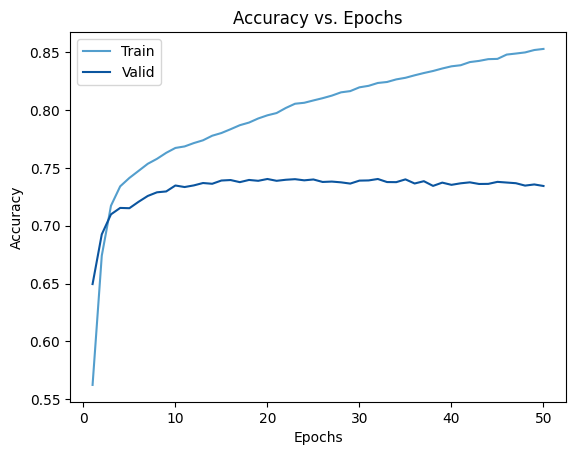

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Accuracy
blues_palette = sns.color_palette("Blues")
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count, y=hist.history['accuracy'], label='Train', color=blues_palette[3])
sns.lineplot(x=epoch_count, y=hist.history['val_accuracy'], label='Valid', color=blues_palette[5])
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.title('Accuracy vs. Epochs')
plt.show()

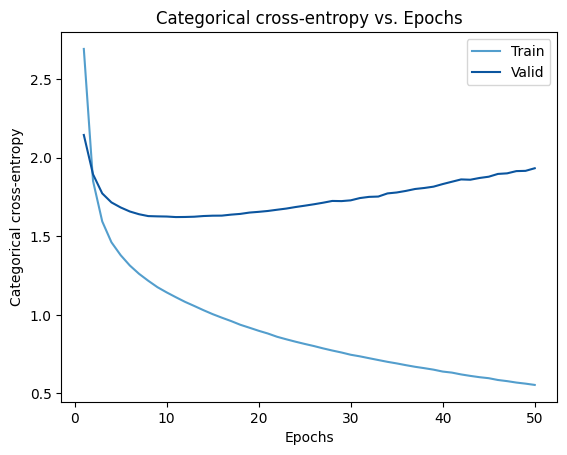

In [20]:
# Loss function
epoch_count = range(1, len(hist.history["loss"]) + 1)
sns.lineplot(x=epoch_count, y=hist.history["loss"], label="Train", color=blues_palette[3])
sns.lineplot(x=epoch_count, y=hist.history["val_loss"], label="Valid", color=blues_palette[5])
plt.ylabel('Categorical cross-entropy')
plt.xlabel('Epochs')
plt.title('Categorical cross-entropy vs. Epochs')
plt.show()

### 5 - Inferencia

In [21]:
idx2word = {v:k for k, v in word2idx.items()}

In [22]:
idx2word = {v:k for k, v in word2idx.items()}

In [23]:
def get_bot_answer(input_seq):
    int_seq = tokenizer.texts_to_sequences([input_seq])[0]
    input_seq = pad_sequences([int_seq], maxlen=max_input_len)

    # Se transforma la sequencia de entrada a los estados "h" y "c" de la LSTM
    # para enviar la primera vez al decoder
    states_value = encoder_model.predict(input_seq)

    # Se inicializa la secuencia de entrada al decoder como "<sos>"
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx['<sos>']

    # Se obtiene el índice que finaliza la inferencia
    eos = word2idx['<eos>']

    output_sentence = []
    for _ in range(max_out_len):
        # Predicción del próximo elemento
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        idx = np.argmax(output_tokens[0, 0, :])

        # Si es "end of sentece <eos>" se acaba
        if eos == idx:
            break

        # Transformar idx a palabra
        word = ''
        if idx > 0:
            word = idx2word[idx]
            output_sentence.append(word)

        # Actualizar los estados dada la última predicción
        states_value = [h, c]

        # Actualizar secuencia de entrada con la salida (re-alimentación)
        target_seq[0, 0] = idx

    return ' '.join(output_sentence)

In [24]:
import sys

def start_chat():
  print("Welcome to the ChatBot.\n (Please type 'quit' to exit)")
  while True:
    # Pido input al usuario
    message = input("")
    print("USER:", message)
    if message.lower() == 'quit':
      break

    if len(message) > 0:
      # Para evitar imprimir el progreso de los pasos durante la inferencia
      original_stdout = sys.stdout
      sys.stdout = open('nul', 'w')
      # Infiero respuesta
      answer = get_bot_answer(message)
      sys.stdout.close()
      sys.stdout = original_stdout
      print("BOT:", answer)

In [25]:
start_chat()

Welcome to the ChatBot.
 (Please type 'quit' to exit)
Hello!
USER: Hello!
BOT: hello how are you
Fine and you?
USER: Fine and you?
BOT: i am not sure what you mean
You play something?
USER: You play something?
BOT: i am not sure what you mean
Can you play?
USER: Can you play?
BOT: i am not sure what you mean
you play?
USER: you play?
BOT: i love to go to the beach
Nice
USER: Nice
BOT: what do you do for a living
I'am a programmer
USER: I'am a programmer
BOT: i love to go to the beach
By
USER: By
BOT: i hope you have a good day
quit
USER: quit


In [26]:
start_chat()

Welcome to the ChatBot.
 (Please type 'quit' to exit)
HI
USER: HI
BOT: hello how are you
Fine, where are you from?
USER: Fine, where are you from?
BOT: i am from the united states
You like to walk?
USER: You like to walk?
BOT: i like to go to the beach
by
USER: by
BOT: i hope you have a good day
quit
USER: quit


In [27]:
start_chat()

Welcome to the ChatBot.
 (Please type 'quit' to exit)
Hello
USER: Hello
BOT: hello how are you
Very good
USER: Very good
BOT: what do you do for a living
play games
USER: play games
BOT: what do you do for a living
i play games
USER: i play games
BOT: what do you do for a living
studing
USER: studing
BOT: i love to read
What are you?
USER: What are you?
BOT: i am not sure what you mean
By
USER: By
BOT: i hope you have a good day
Quit
USER: Quit


### 6 - Conclusión

El bot de conversación se comportó bastante bien ante una conversación muy simple. Sus respuestas se adecuan y en algunas ocaciones no supo interpretar la conversación. De todas maneras parece poder responder solo preguntas muy directas y especificas, posiblemente por la falta de vocabulario o entrenamiento.

Se podrian obtener mejores resultados con una muestra de datos mayor para tener una fuente mas rica de vocabularios y posibles respuestas a mas interacciones. También podria ajustarse en mejor medida el entrenamiento del modelo siempre y cuando no tienda a memorizar resultados.

En ocaciones siempre responde con lo mismo, lo que de alguna manera estaria memorizando respuestas.